In [40]:
import pandas as pd
from db.connection import get_connection, get_cursor
from db.queries import read_entries_query

def fetch_data_from_db():
    try:
        with get_connection() as conn:
            with get_cursor(conn) as cursor:
                # Execute the SQL query
                query = read_entries_query()  # Adjust this query to fetch the necessary data
                cursor.execute(query)
                
                # Fetch the data
                rows = cursor.fetchall()
                
                # Get column names from cursor description
                columns = [desc[0] for desc in cursor.description]
                
                # Convert to DataFrame
                df = pd.DataFrame(rows, columns=columns)
                
                # Rename 'ts' to 'timestamp' for consistency
                if 'ts' in df.columns:
                    df.rename(columns={'ts': 'timestamp'}, inplace=True)
                
                return df
    except Exception as e:
        print(f"Error fetching data from database: {e}")
        return None

# Fetch the data
df = fetch_data_from_db()

# Check if DataFrame is not None and has the correct columns
if df is not None:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Print the DataFrame to verify
    print(df.head())
else:
    print("Failed to fetch data or DataFrame is empty.")


Connection established.
Cursor created.
Cursor closed.
Connection closed.
            timestamp  temperature  humidity                   id   rpm
0 2024-09-03 15:27:41        25.10     33.67  2593882550564710339  1201
1 2024-09-03 15:27:46        24.09     44.02  2989760304231902125  1572
2 2024-09-03 15:27:51        20.92     36.41  7671935893463117331  1535
3 2024-09-03 15:27:56        22.18     49.45  3333762746264666090  1748
4 2024-09-03 15:28:01        19.46     46.35  8723722878037460563  1761


In [41]:
print(df.dtypes)


timestamp      datetime64[ns]
temperature           float64
humidity              float64
id                      int64
rpm                     int64
dtype: object


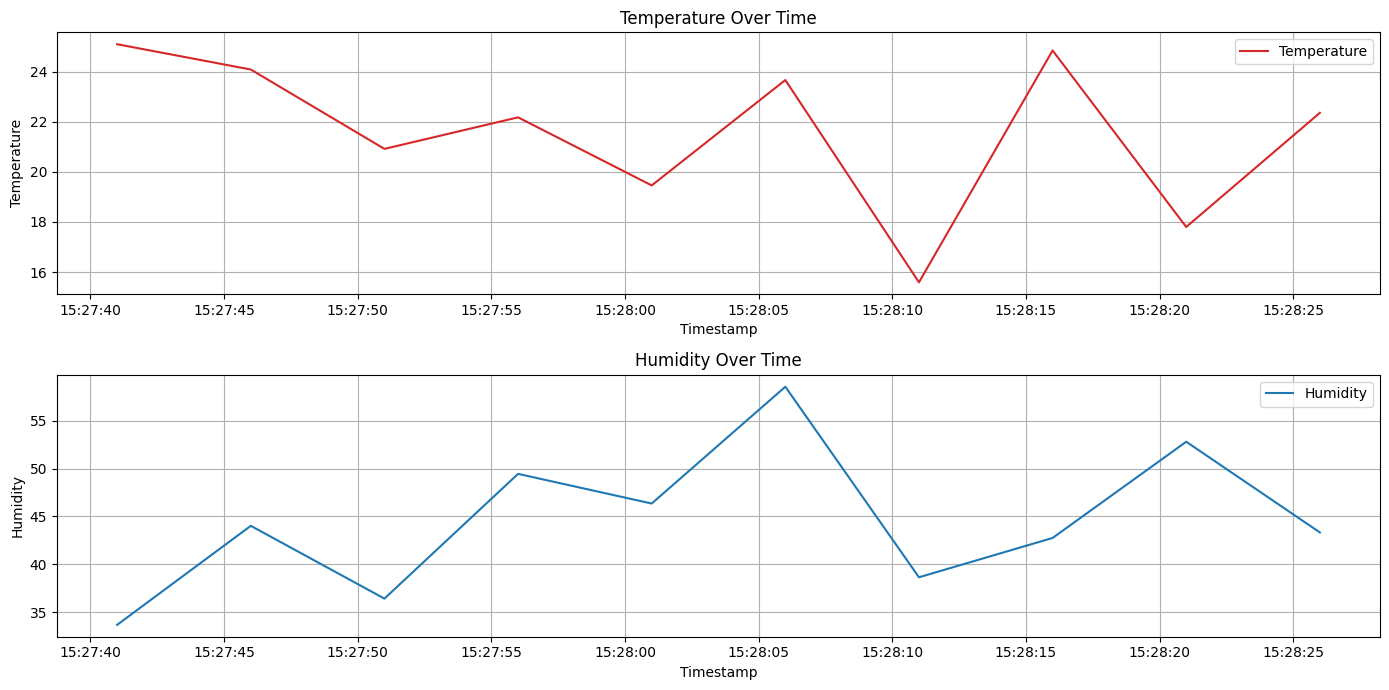

In [42]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='tab:red')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['timestamp'], df['humidity'], label='Humidity', color='tab:blue')
plt.xlabel('Timestamp')
plt.ylabel('Humidity')
plt.title('Humidity Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:
print(df.describe())



                           timestamp  temperature   humidity            id  \
count                             10    10.000000  10.000000  1.000000e+01   
mean      2024-09-03 15:28:03.500000    21.602000  44.599000  5.607806e+18   
min              2024-09-03 15:27:41    15.590000  33.670000  2.593883e+18   
25%    2024-09-03 15:27:52.249999872    19.825000  39.667500  3.624238e+18   
50%       2024-09-03 15:28:03.500000    22.270000  43.675000  5.483547e+18   
75%    2024-09-03 15:28:14.750000128    23.985000  48.675000  7.490457e+18   
max              2024-09-03 15:28:26    25.100000  58.560000  8.723723e+18   
std                              NaN     3.159001   7.574116  2.262842e+18   

               rpm  
count    10.000000  
mean   1516.800000  
min    1025.000000  
25%    1340.500000  
50%    1553.500000  
75%    1757.750000  
max    1804.000000  
std     269.857905  


In [44]:
correlations = df[['temperature', 'humidity', 'rpm']].corr()
print(correlations)


             temperature  humidity       rpm
temperature     1.000000 -0.039569  0.383181
humidity       -0.039569  1.000000  0.534896
rpm             0.383181  0.534896  1.000000


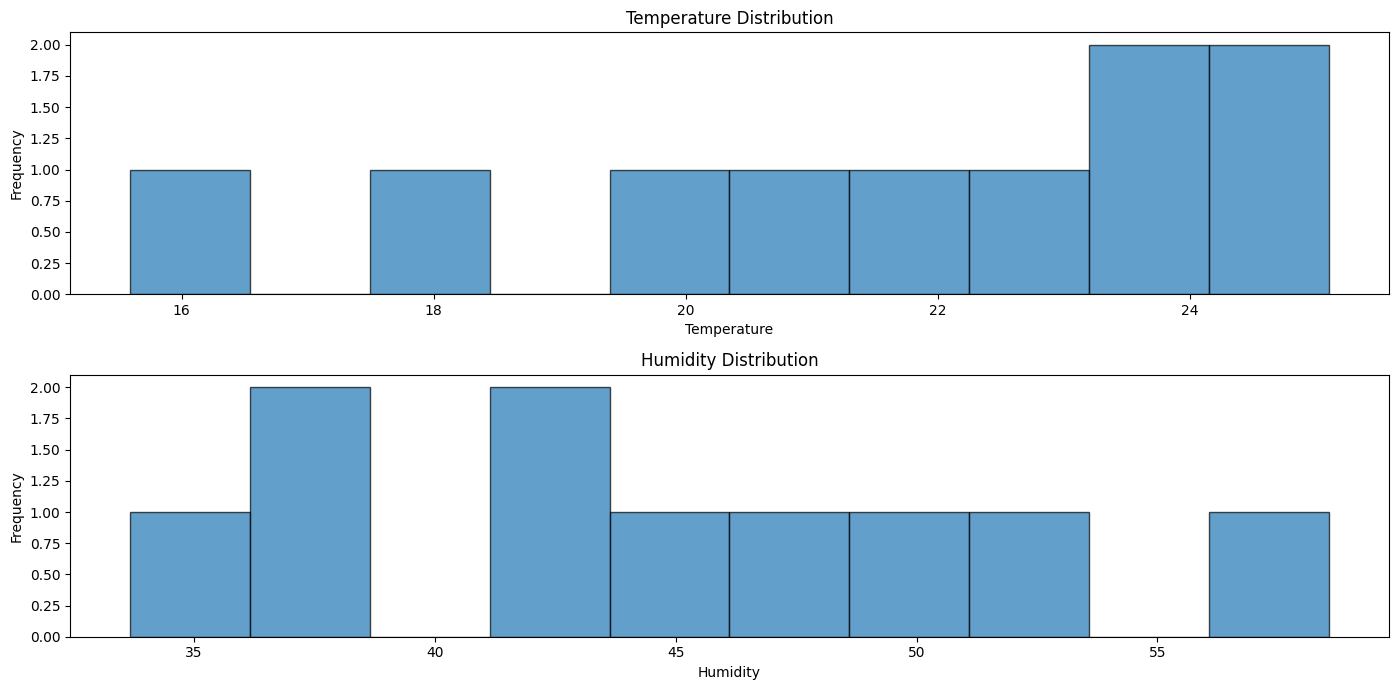

In [45]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.hist(df['temperature'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')

plt.subplot(2, 1, 2)
plt.hist(df['humidity'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Humidity Distribution')

plt.tight_layout()
plt.show()



In [46]:
df_hourly = df.resample('H', on='timestamp').mean()
print(df_hourly)


                     temperature  humidity            id     rpm
timestamp                                                       
2024-09-03 15:00:00       21.602    44.599  5.607806e+18  1516.8


/tmp/ipykernel_141266/3085794060.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='timestamp').mean()


In [47]:
start_time = '2024-09-03 13:37:00'
end_time = '2024-09-03 13:38:00'
filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
print(filtered_df)


Empty DataFrame
Columns: [timestamp, temperature, humidity, id, rpm]
Index: []


In [48]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA
df.set_index('timestamp', inplace=True)

# Forecasting temperature
temperature_series = df['temperature']
temp_model = ARIMA(temperature_series, order=(1, 1, 1))
temp_model_fit = temp_model.fit()
temp_forecast = temp_model_fit.forecast(steps=5)
print("Temperature Forecast:")
print(temp_forecast)

# Forecasting humidity
humidity_series = df['humidity']
humidity_model = ARIMA(humidity_series, order=(1, 1, 1))
humidity_model_fit = humidity_model.fit()
humidity_forecast = humidity_model_fit.forecast(steps=5)
print("Humidity Forecast:")
print(humidity_forecast)


Temperature Forecast:
2024-09-03 15:28:31    18.850622
2024-09-03 15:28:36    21.699875
2024-09-03 15:28:41    19.386575
2024-09-03 15:28:46    21.264736
2024-09-03 15:28:51    19.739863
Freq: 5s, Name: predicted_mean, dtype: float64
Humidity Forecast:
2024-09-03 15:28:31    47.434683
2024-09-03 15:28:36    46.141895
2024-09-03 15:28:41    46.549064
2024-09-03 15:28:46    46.420824
2024-09-03 15:28:51    46.461214
Freq: 5s, Name: predicted_mean, dtype: float64


/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5s will be used.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5s will be used.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5s will be used.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5s will be used.
  self._init_dates(dates, freq)
/home/azharudeen/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was p